# Week 4: NLP Disaster Tweets Kaggle Mini-Project

This project is for a submission to this Kaggle Competition: 
Kaggle competition: Natural Language Processing with Disaster Tweets

#### Competition Description
Twitter has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 



## Step 1: Brief Description of Problem and Data

The challenge is to predicts which Tweets are about real disasters and which one’s aren’t using NLP

### Data

Data is provided in two files:
* trains.csv - the training set
* test.csv - the test set

Each dataset includes
* ID - a unique identified for each tweet
* text - the text of the tweet
* location - location the tweet was sent from
* keyword - particular keyword from the tweet
* target - in train.csv, this denoted whether a tweet is about a read disaster or not

## Step 2: EDA

EDA will focus on whether it makes sense to include location and keywords as part of the training process.

In [ ]:
!pip -q install kaggle matplotlib seaborn wordcloud nltk

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-04-24 02:00:40.043604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 02:00:40.043634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 02:00:40.044790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 02:00:40.050206: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwor

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
!unzip -o glove.6B.zip glove.6B.100d.txt
!rm glove.6B.zip


In [2]:
# Verify GPUs are available
print("TensorFlow version:", tf.__version__)
print("Number of available GPUs:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.15.0
Number of available GPUs: 2
Memory growth enabled for GPUs.


2024-04-24 02:00:45.588940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 02:00:45.589167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 02:00:45.595787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
home_path = os.environ['HOME']
os.makedirs(f"{home_path}/.kaggle", exist_ok=True)
!cp ./kaggle.json {home_path}/.kaggle/
!chmod 600 {home_path}/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started
!unzip -q nlp-getting-started.zip -d ./data

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
print("Total number of tweets:", len(train_df))
print("Proportion of disaster tweets:", train_df['target'].mean())
print("Proportion of non-disaster tweets:", 1 - train_df['target'].mean())
print("Number of unique locations:", train_df['location'].nunique())
print("Number of unique keywords:", train_df['keyword'].nunique())

Total number of tweets: 7613
Proportion of disaster tweets: 0.4296597924602653
Proportion of non-disaster tweets: 0.5703402075397347
Number of unique locations: 3341
Number of unique keywords: 221


Percentage of tweets with non-empty location: 66.72796532247472


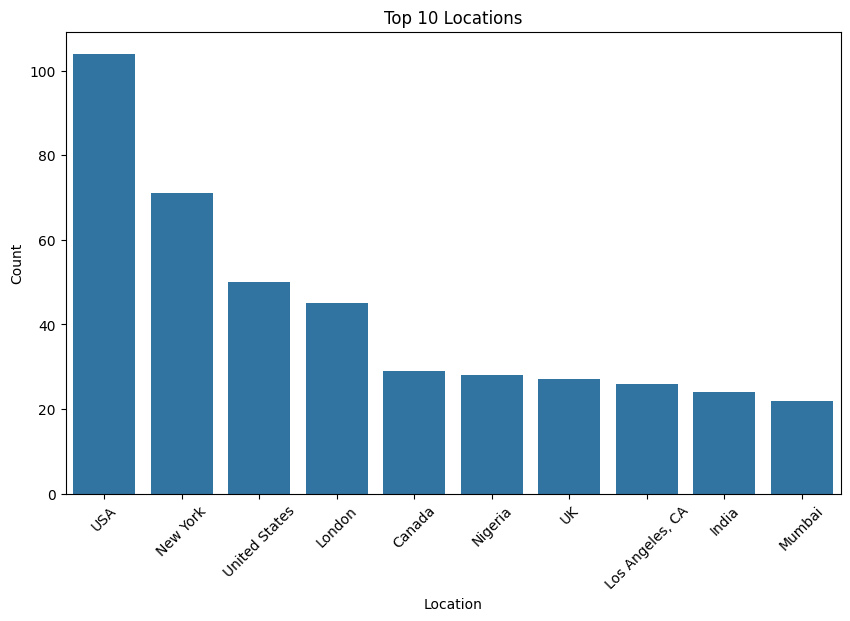

In [5]:
print("Percentage of tweets with non-empty location:", (train_df['location'].notna().sum() / len(train_df)) * 100)
location_counts = train_df['location'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.index[:10], y=location_counts.values[:10])
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Percentage of tweets with non-empty keyword: 99.19873899908052


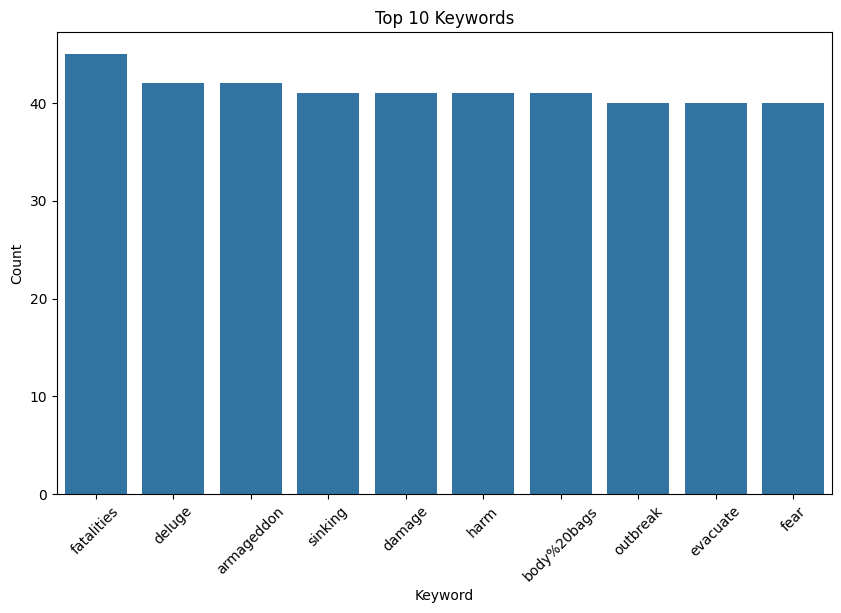

In [6]:
print("Percentage of tweets with non-empty keyword:", (train_df['keyword'].notna().sum() / len(train_df)) * 100)
keyword_counts = train_df['keyword'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_counts.index[:10], y=keyword_counts.values[:10])
plt.title('Top 10 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_2403/3829399607.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['text'] = train_df['text'].str.replace('[^\w\s]', '')


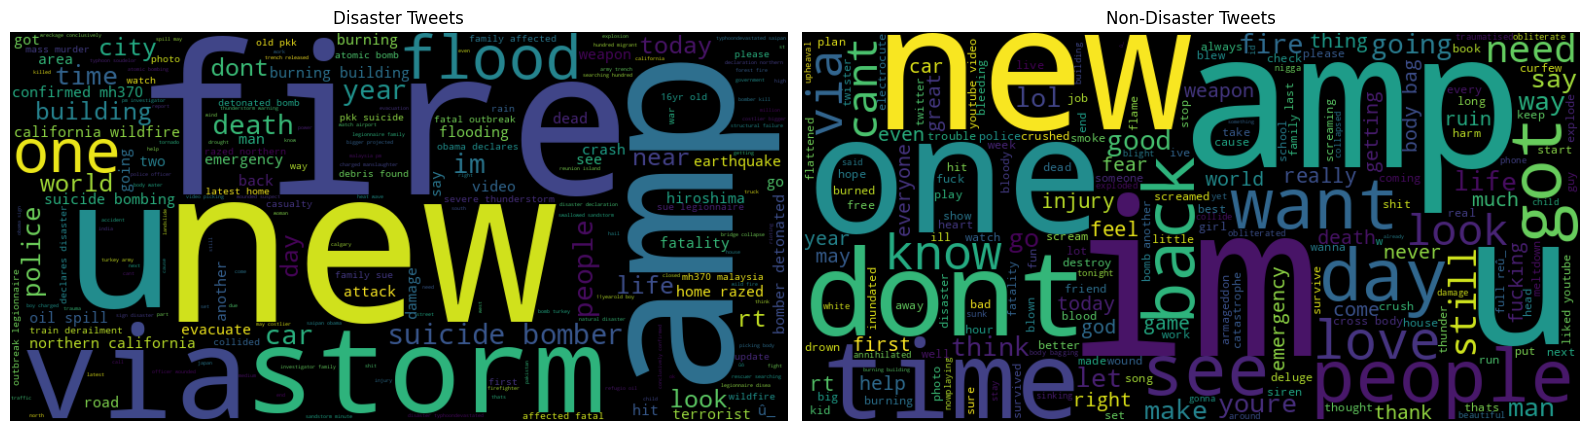

In [7]:
train_df['text'] = train_df['text'].str.lower()
train_df['text'] = train_df['text'].str.replace('[^\w\s]', '')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)

disaster_texts = train_df[train_df['target'] == 1]['preprocessed_text']
non_disaster_texts = train_df[train_df['target'] == 0]['preprocessed_text']

disaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(disaster_texts))
non_disaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(non_disaster_texts))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets')

plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoding on the 'location' column
location_encoder = LabelEncoder()
train_df['location_encoded'] = location_encoder.fit_transform(train_df['location'])

# Perform label encoding on the 'keyword' column
keyword_encoder = LabelEncoder()
train_df['keyword_encoded'] = keyword_encoder.fit_transform(train_df['keyword'])

print("Correlation between location and target:", train_df['location_encoded'].corr(train_df['target']))
print("Correlation between keyword and target:", train_df['keyword_encoded'].corr(train_df['target']))

print("Percentage of missing values for location:", (train_df['location'].isna().sum() / len(train_df)) * 100)
print("Percentage of missing values for keyword:", (train_df['keyword'].isna().sum() / len(train_df)) * 100)

Correlation between location and target: -0.002955651807419477
Correlation between keyword and target: 0.062169589169883646
Percentage of missing values for location: 33.27203467752528
Percentage of missing values for keyword: 0.8012610009194797


### EDA Analysis

Considering these observations, it doesn't make sense to include 'location' and 'keyword' features in the train process. 

Summary of observations:

1. **Weak correlation**: Both features have low correlation with the target variable, suggesting that they may not provide significant predictive power.
2. **High dimensionality**: The large number of unique locations and keywords can introduce high dimensionality to the feature space, which may lead to increased complexity and potential overfitting.
3. **Missing values**: The high percentage of missing values for the 'location' feature may require additional handling techniques and could introduce noise or bias if not addressed properly.

## Step 3: Model Architecture

We will explore two models: LSTM and Bidirectional GRU Model.

LSTM networks are effective for sequence prediction problems because they can maintain long-term dependencies.

Bidirectional GRUs provide the advantage of processing inputs in both forward and backward directions, capturing dependencies that may be missed by unidirectional models.

### Define Helper Functions

In [23]:
def compare_models(history1, history2, model_name1, model_name2):
    acc1 = history1.history['accuracy']
    loss1 = history1.history['loss']
    acc2 = history2.history['accuracy']
    loss2 = history2.history['loss']
    epochs = range(1, len(acc1) + 1)

    # Plot the accuracy comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc1, 'b', label=f'{model_name1} accuracy')
    plt.plot(epochs, acc2, 'r', label=f'{model_name2} accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot the loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss1, 'b', label=f'{model_name1} loss')
    plt.plot(epochs, loss2, 'r', label=f'{model_name2} loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

### Data Preparations

In [59]:
texts = train_df['preprocessed_text'].tolist()
labels = train_df['target'].tolist()

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Fit only on training data to avoid information leakage

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Pad the sequences to have equal length
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in val_sequences))  # Consider max length from both sets
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

print(f"Shape of train_padded: {train_padded.shape}")
print(f"Shape of val_padded: {val_padded.shape}")

Shape of train_padded: (6090, 25)
Shape of val_padded: (1523, 25)


### Word Embeddings using GloVe

GloVe, or Global Vectors for Word Representation, is an unsupervised learning algorithm designed to generate word embeddings by leveraging global statistical information of word co-occurrences from large text datasets. These embeddings encode semantic relationships between words in dense vector representations, facilitating tasks such as natural language understanding and classification. In this experimentation, GloVe embeddings are advantageous due to their ability to capture nuanced semantic similarities between words, providing the model with rich contextual information to improve accuracy in classifying tweets as real disasters or not.

In [60]:
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load the GloVe embeddings
glove_path = 'glove.6B.100d.txt'  # Make sure you've downloaded this file as explained previously
embeddings_index = load_glove_embeddings(glove_path)

embedding_dim = 100  # Dimension of the GloVe vectors you have
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because index 0 is reserved in Keras

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe vectors
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model Definition
#### Optimizers

In [61]:
learning_rate = 1e-5 

#### LSTM

In [62]:
def create_lstm_model(learning_rate, embedding_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=max_length, trainable=False, mask_zero=True))
    model.add(Masking(mask_value=0.0))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_lstm = create_lstm_model(learning_rate, embedding_dim)
model_lstm.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 25, 100)           1821700   
                                                                 
 masking_41 (Masking)        (None, 25, 100)           0         
                                                                 
 bidirectional_38 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1906309 (7.27 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 1821700 (6.95 MB)
___________

#### Bidirectional GRU

In [63]:
def create_gru_model(learning_rate, embedding_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                        input_length=max_length, trainable=False, mask_zero=True))
    model.add(Masking(mask_value=0.0))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_gru = create_gru_model(learning_rate, embedding_dim)
model_gru.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 25, 100)           1821700   
                                                                 
 masking_42 (Masking)        (None, 25, 100)           0         
                                                                 
 bidirectional_39 (Bidirect  (None, 128)               63744     
 ional)                                                          
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1885573 (7.19 MB)
Trainable params: 63873 (249.50 KB)
Non-trainable params: 1821700 (6.95 MB)
___________

### Model Training

In [64]:
epochs = 10
batch_size = 32

In [65]:
train_labels = np.array(train_labels)
val_labels  = np.array(val_labels)

history_lstm = model_lstm.fit(train_padded, train_labels, epochs=epochs,
                              validation_data=(val_padded, val_labels), batch_size=batch_size, verbose=2)

Epoch 1/10
191/191 - 14s - loss: 0.7146 - accuracy: 0.4903 - val_loss: 0.6970 - val_accuracy: 0.5200 - 14s/epoch - 73ms/step
Epoch 2/10
191/191 - 9s - loss: 0.6980 - accuracy: 0.5251 - val_loss: 0.6792 - val_accuracy: 0.5798 - 9s/epoch - 45ms/step
Epoch 3/10
191/191 - 9s - loss: 0.6755 - accuracy: 0.5724 - val_loss: 0.6626 - val_accuracy: 0.6257 - 9s/epoch - 45ms/step
Epoch 4/10
191/191 - 9s - loss: 0.6595 - accuracy: 0.6102 - val_loss: 0.6467 - val_accuracy: 0.6658 - 9s/epoch - 46ms/step
Epoch 5/10
191/191 - 8s - loss: 0.6434 - accuracy: 0.6465 - val_loss: 0.6314 - val_accuracy: 0.6973 - 8s/epoch - 44ms/step
Epoch 6/10
191/191 - 8s - loss: 0.6294 - accuracy: 0.6688 - val_loss: 0.6164 - val_accuracy: 0.7242 - 8s/epoch - 44ms/step
Epoch 7/10
191/191 - 9s - loss: 0.6144 - accuracy: 0.6918 - val_loss: 0.6018 - val_accuracy: 0.7420 - 9s/epoch - 48ms/step
Epoch 8/10
191/191 - 9s - loss: 0.5996 - accuracy: 0.7172 - val_loss: 0.5878 - val_accuracy: 0.7505 - 9s/epoch - 47ms/step
Epoch 9/10
191

In [66]:
history_gru = model_gru.fit(train_padded, train_labels, epochs=epochs,
                            validation_data=(val_padded, val_labels), batch_size=batch_size, verbose=2)

Epoch 1/10
191/191 - 13s - loss: 0.6838 - accuracy: 0.5744 - val_loss: 0.6563 - val_accuracy: 0.6074 - 13s/epoch - 69ms/step
Epoch 2/10
191/191 - 9s - loss: 0.6679 - accuracy: 0.5984 - val_loss: 0.6421 - val_accuracy: 0.6369 - 9s/epoch - 46ms/step
Epoch 3/10
191/191 - 9s - loss: 0.6509 - accuracy: 0.6172 - val_loss: 0.6295 - val_accuracy: 0.6605 - 9s/epoch - 46ms/step
Epoch 4/10
191/191 - 9s - loss: 0.6437 - accuracy: 0.6222 - val_loss: 0.6178 - val_accuracy: 0.6756 - 9s/epoch - 45ms/step
Epoch 5/10
191/191 - 9s - loss: 0.6297 - accuracy: 0.6507 - val_loss: 0.6071 - val_accuracy: 0.6888 - 9s/epoch - 47ms/step
Epoch 6/10
191/191 - 9s - loss: 0.6220 - accuracy: 0.6558 - val_loss: 0.5972 - val_accuracy: 0.6986 - 9s/epoch - 45ms/step
Epoch 7/10
191/191 - 9s - loss: 0.6068 - accuracy: 0.6810 - val_loss: 0.5880 - val_accuracy: 0.7098 - 9s/epoch - 45ms/step
Epoch 8/10
191/191 - 9s - loss: 0.5975 - accuracy: 0.6874 - val_loss: 0.5794 - val_accuracy: 0.7236 - 9s/epoch - 47ms/step
Epoch 9/10
191

### Initial Model Comparison 

48/48 [==============================] - 1s 14ms/step - loss: 0.5264 - accuracy: 0.7833
LSTM Model Validation Accuracy: 0.7833223938941956
48/48 [==============================] - 1s 12ms/step - loss: 0.5809 - accuracy: 0.7472
GRU Model Validation Accuracy: 0.7472094297409058


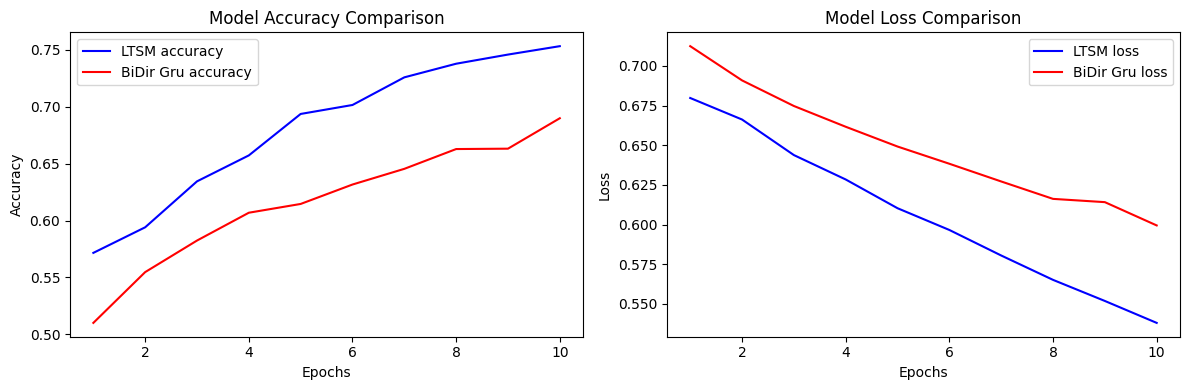

In [45]:
# Evaluate LSTM Model
loss_lstm, accuracy_lstm = model_lstm.evaluate(val_padded, val_labels)
print(f"LSTM Model Validation Accuracy: {accuracy_lstm}")

# Evaluate GRU Model
loss_gru, accuracy_gru = model_gru.evaluate(val_padded, val_labels)
print(f"GRU Model Validation Accuracy: {accuracy_gru}")

compare_models(history_lstm, history_gru, "LTSM", "BiDir Gru")

## Results and Analysis

We execute three different experiments to try and arrive at the best possible model configuration

1. Varying Learning Rate: Investigate the impact of different learning rates on model performance.
2. Varying Batch Sizes: Explore the effect of different batch sizes on model performance
3. Varying Number of Epochs: Invistigate the impact of training for more epochs on model performance

The experiments will build on each other, so the results of experiment 1 will be in used in experiment 2 and so on.

In [51]:
def train_and_evaluate(model, train_data, train_labels, val_data, val_labels, epochs, batch_size):
    history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(val_data, val_labels),
                        batch_size=batch_size, verbose=0)
    _, val_accuracy = model.evaluate(val_data, val_labels, verbose=0)
    return val_accuracy

### Experiment 1 - Varying Learning Rate

In [52]:
def experiment_learning_rate(embedding_dim):
    learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
    batch_size = 32
    epochs = 10

    lstm_results = []
    gru_results = []

    for lr in learning_rates:
        lstm_model = create_lstm_model(lr, embedding_dim)
        gru_model = create_gru_model(lr, embedding_dim)

        lstm_accuracy = train_and_evaluate(lstm_model, train_padded, train_labels, val_padded, val_labels, epochs, batch_size)
        gru_accuracy = train_and_evaluate(gru_model, train_padded, train_labels, val_padded, val_labels, epochs, batch_size)

        lstm_results.append(lstm_accuracy)
        gru_results.append(gru_accuracy)

    results_df = pd.DataFrame({'Learning Rate': learning_rates, 'LSTM Accuracy': lstm_results, 'GRU Accuracy': gru_results})
    print("Experiment 1: Varying Learning Rate")
    print(results_df)
    
experiment_learning_rate(embedding_dim)

Experiment 1: Varying Learning Rate
   Learning Rate  LSTM Accuracy  GRU Accuracy
0       0.001000       0.799737      0.774787
1       0.000100       0.808273      0.808930
2       0.000010       0.764938      0.724229
3       0.000001       0.623769      0.556139


#### Result

Both models performed best with learning rate = **0.001**

### Experiment 2 - Varying Batch Size

In [54]:
def experiment_batch_size(embedding_dim):
    learning_rate = 0.0001
    batch_sizes = [16, 32, 64, 128]
    epochs = 10

    lstm_results = []
    gru_results = []

    for bs in batch_sizes:
        lstm_model = create_lstm_model(learning_rate, embedding_dim)
        gru_model = create_gru_model(learning_rate, embedding_dim)

        lstm_accuracy = train_and_evaluate(lstm_model, train_padded, train_labels, val_padded, val_labels, epochs, bs)
        gru_accuracy = train_and_evaluate(gru_model, train_padded, train_labels, val_padded, val_labels, epochs, bs)

        lstm_results.append(lstm_accuracy)
        gru_results.append(gru_accuracy)

    results_df = pd.DataFrame({'Batch Size': batch_sizes, 'LSTM Accuracy': lstm_results, 'GRU Accuracy': gru_results})
    print("\nExperiment 2: Varying Batch Size")
    print(results_df)
    
experiment_batch_size(embedding_dim)


Experiment 2: Varying Batch Size
   Batch Size  LSTM Accuracy  GRU Accuracy
0          16       0.815496      0.807617
1          32       0.809586      0.808273
2          64       0.811556      0.801051
3         128       0.803677      0.795798


#### Result

Not much difference but batch size **16** results slightly larger accuracy for LTSM and bat size **32** for GRU, so we will carry those forward

### Experiment 3 - Varying Number of Epochs

In [56]:
def experiment_num_epochs(embedding_dim):
    learning_rate = 0.0001
    lstm_batch_size = 16
    gru_batch_size = 32
    num_epochs = [10, 20, 30]

    lstm_results = []
    gru_results = []

    for epochs in num_epochs:
        lstm_model = create_lstm_model(learning_rate, embedding_dim)
        gru_model = create_gru_model(learning_rate, embedding_dim)

        lstm_accuracy = train_and_evaluate(lstm_model, train_padded, train_labels, val_padded, val_labels, epochs, lstm_batch_size)
        gru_accuracy = train_and_evaluate(gru_model, train_padded, train_labels, val_padded, val_labels, epochs, gru_batch_size)

        lstm_results.append(lstm_accuracy)
        gru_results.append(gru_accuracy)

    results_df = pd.DataFrame({'Epochs': num_epochs, 'LSTM Accuracy': lstm_results, 'GRU Accuracy': gru_results})
    print("\nExperiment 3: Varying Number of Epochs")
    print(results_df)
    
experiment_num_epochs(embedding_dim)


Experiment 3: Varying Number of Epochs
   Epochs  LSTM Accuracy  GRU Accuracy
0      10       0.812213      0.804990
1      20       0.814839      0.812213
2      30       0.796454      0.814183


## Conclusion

The hyperparameter tuning experiments provided valuable insights into the performance of LSTM and GRU models for sentiment analysis. The results showed that a moderate learning rate of 0.0001, smaller batch sizes (16 and 32), and an appropriate number of epochs (20 for LSTM, 30 for GRU) yielded the best performance. The use of pre-trained word embeddings and bidirectional architectures contributed to the models' ability to capture sentiment information.
However, there is still room for improvement. Future experiments could explore fine-tuning word embeddings, increasing model complexity, applying regularization techniques, using ensemble methods, and augmenting the training data. These techniques have the potential to enhance the models' ability to learn complex patterns, mitigate overfitting, and improve generalization.
In conclusion, while the LSTM and GRU models achieved reasonable accuracy, further optimization and exploration of advanced techniques could lead to even better performance in sentiment analysis tasks.

## Submission Code and Reference List
1. I will use the LSTM model for my submission
2. I did not use any specific references but relied on previous knowledge and AI assistants from OpenAI (i.e ChatGPT)

In [69]:
learning_rate = 0.0001
batch_size = 20
num_epochs = 20
final_model = create_lstm_model(learning_rate, embedding_dim)
history = final_model.fit(train_padded, 
                    train_labels, 
                    epochs=epochs, 
                    validation_data=(val_padded, val_labels),
                    batch_size=batch_size, 
                    verbose=0)

In [72]:
test_df['text'] = test_df['text'].str.lower()
test_df['text'] = test_df['text'].str.replace('[^\w\s]', '')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

embedding_layer = final_model.layers[0]
embedding_layer.set_weights([embedding_matrix])

predictions = final_model.predict(test_padded)
predicted_classes = np.round(predictions).astype(int)

output_data = pd.DataFrame({'id': test_df['id'], 'target': predicted_classes.flatten()})

# Save the DataFrame to a CSV file
output_data.to_csv('submission.csv', index=False)

  1/102 [..............................] - ETA: 2s

/tmp/ipykernel_2403/3079706579.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace('[^\w\s]', '')


102/102 [==============================] - 1s 9ms/step
